In [1]:
import jieba
import jieba.posseg as pseg
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

/home/rhea/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
pd.set_option("display.max_columns", None)

# load data

In [3]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [4]:
train.head(10)

,stock_id,stock_name,event_date,TCRI(m/y),importance,class,category,event_content
0,1218,泰山,20190101,6(2018/09),0,M_經營層,MT06_高管異動,發言人林俐婉內部調動，由江巍峰接任。
1,1503,士電,20190101,4(2018/09),0,M_經營層,MT06_高管異動,內部稽核主管林志強內部調動，由莊文清接任。
2,1504,東元,20190101,4(2018/09),0,M_經營層,MT06_高管異動,會計主管藍俊雄內部調動，由林鴻名接任。
3,1709,和益,20190101,5(2018/09),0,M_經營層,MT06_高管異動,內部稽核主管游本詮內部調動，由曾筱茜接任。
4,1721,三晃,20190101,7(2018/09),0,M_經營層,MT06_高管異動,財務經理洪廷宜內部調動，由王婷渝接任。
5,1817,凱撒衛,20190101,6(2018/09),0,M_經營層,MT06_高管異動,研發主管吳政峰內部調動，由朱清立接任。
6,2064,晉椿,20190101,7(2018/09),-1,M_經營層,MT06_高管異動,總經理高進義離職，由陳譽接任。發言人高進義離職，由陳譽接任。
7,2207,和泰車,20190101,4(2018/09),0,M_經營層,MT02_董監異動,改派1董。董事大野勝仁(豐田自動車代表)卸任。董事長沼一生(豐田自動車代表)新任。
8,2330,台積電,20190101,1(2018/09),-1,M_經營層,MT02_董監異動,辭任1董。獨立董事湯馬斯?延吉布斯卸任。
9,2357,華碩,20190101,2(2018/09),0,M_經營層,MT06_高管異動,總經理沈振來內部調動，由胡書賓接任。


# plot

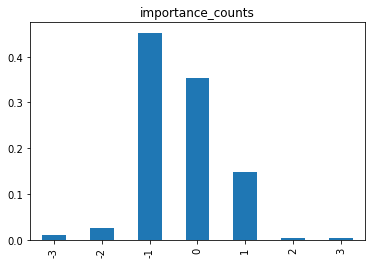

In [5]:
(train['importance'].value_counts() / len(train)).sort_index().plot.bar(title='importance_counts')

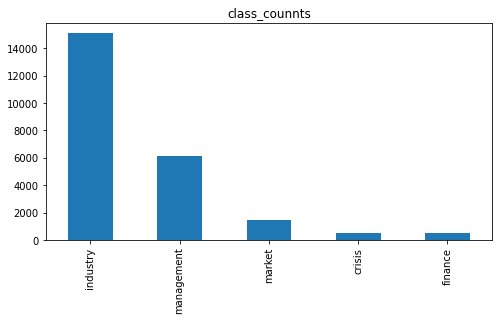

In [6]:
class_map = {
    'I_產業前景': 'industry',
    'M_經營層': 'management',
    'F_市場交易': 'market',
    'R_危機': 'crisis',
    'A_會計/財報分析': 'finance'
}

train['class'].map(class_map).value_counts().plot.bar(title='class_counnts', figsize=(8, 4))

M_經營層


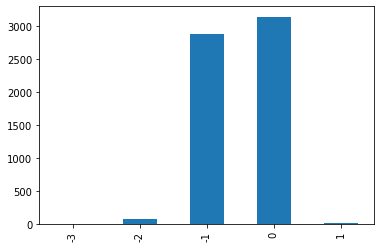

F_市場交易


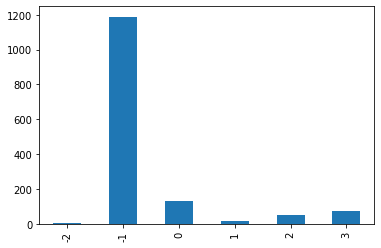

I_產業前景


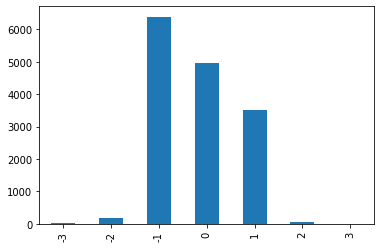

R_危機


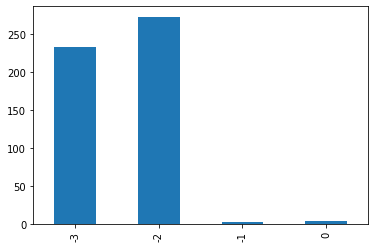

A_會計/財報分析


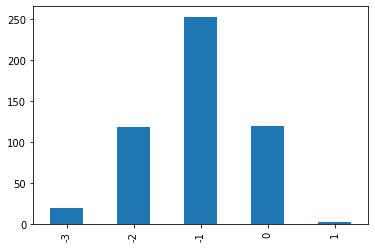

In [7]:
for c in train['class'].unique():
    print(c)
    target = train[train['class'] == c]
    target['importance'].value_counts().sort_index().plot.bar()
    plt.show()

# word segmentation

In [8]:
train.head(10)

,stock_id,stock_name,event_date,TCRI(m/y),importance,class,category,event_content
0,1218,泰山,20190101,6(2018/09),0,M_經營層,MT06_高管異動,發言人林俐婉內部調動，由江巍峰接任。
1,1503,士電,20190101,4(2018/09),0,M_經營層,MT06_高管異動,內部稽核主管林志強內部調動，由莊文清接任。
2,1504,東元,20190101,4(2018/09),0,M_經營層,MT06_高管異動,會計主管藍俊雄內部調動，由林鴻名接任。
3,1709,和益,20190101,5(2018/09),0,M_經營層,MT06_高管異動,內部稽核主管游本詮內部調動，由曾筱茜接任。
4,1721,三晃,20190101,7(2018/09),0,M_經營層,MT06_高管異動,財務經理洪廷宜內部調動，由王婷渝接任。
5,1817,凱撒衛,20190101,6(2018/09),0,M_經營層,MT06_高管異動,研發主管吳政峰內部調動，由朱清立接任。
6,2064,晉椿,20190101,7(2018/09),-1,M_經營層,MT06_高管異動,總經理高進義離職，由陳譽接任。發言人高進義離職，由陳譽接任。
7,2207,和泰車,20190101,4(2018/09),0,M_經營層,MT02_董監異動,改派1董。董事大野勝仁(豐田自動車代表)卸任。董事長沼一生(豐田自動車代表)新任。
8,2330,台積電,20190101,1(2018/09),-1,M_經營層,MT02_董監異動,辭任1董。獨立董事湯馬斯?延吉布斯卸任。
9,2357,華碩,20190101,2(2018/09),0,M_經營層,MT06_高管異動,總經理沈振來內部調動，由胡書賓接任。


In [9]:
# jieba.enable_parallel(8)

corpus = train['event_content'][0]
for word, flag in pseg.cut(corpus):
    print(word, flag)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.428 seconds.
Prefix dict has been built successfully.


發言 v
人 n
林俐婉 nr
內部 f
調動 vn
， x
由 p
江巍峰 nr
接任 v
。 x


In [10]:
def sentence_segment(x):
    x = x.replace(',', '')
    segment = pseg.cut(x)
    return ' '.join([word for word, flag in segment])


# train_corpus = train['event_content'].apply(sentence_segment)
# test_corpus = test['event_content'].apply(sentence_segment)

In [11]:
# read segmented data
train = pd.read_csv("../data/train_with_segment.csv")
test = pd.read_csv('../data/test_with_segment.csv')
train_corpus = train.corpus
test_corpus = test.corpus

In [12]:
for i in range(5):
    print(test['event_content'][i])
    print(test_corpus[i])
    print('')

內部稽核主管游慧芬離職，由周昆伯接任。財務經理張碧真內部調動，由葉能律接任。會計主管張碧真內部調動，由葉能律接任。
內部 稽核 主管 游慧芬 離職 ， 由 周昆伯 接任 。 財務 經理 張碧真 內部 調動 ， 由 葉能律 接任 。 會計 主管 張碧真 內部 調動 ， 由 葉能律 接任 。

內部稽核主管游慧芬離職，由周昆伯接任。財務經理張碧真內部調動，由葉能律接任。會計主管張碧真內部調動，由葉能律接任。
內部 稽核 主管 游慧芬 離職 ， 由 周昆伯 接任 。 財務 經理 張碧真 內部 調動 ， 由 葉能律 接任 。 會計 主管 張碧真 內部 調動 ， 由 葉能律 接任 。

內部稽核主管張美惠內部調動，由林立人接任。
內部 稽核 主管 張 美惠 內部 調動 ， 由 林立 人 接任 。

永冠-KY隨著離岸風電大型鑄件需求持續增溫，2019年12月出貨勝過11月15,023噸，前11月出貨噸數達147,602噸，。年增23%；2020年出貨噸數目標則訂為19.6萬噸。此外，永冠配合客戶西門子歌美颯再生能源拿到海能風場風機訂。單，在台中港區租地建廠案，預計2020年第一季會向台中市政府提出建廠申請。另規畫2020年產業機械及注塑機等。非風電鑄件產能，將轉化為生產風電中小型鑄件，產品開發及認證需要時間，轉換效應會從2020年開始顯現。
永冠 - KY 隨著 離岸 風電 大型 鑄件 需求 持續 增溫 ， 2019 年 12 月 出貨 勝 過 11 月 15023 噸 ， 前 11 月 出 貨噸數 達 147602 噸 ， 。 年 增 23 % ； 2020 年 出 貨噸數 目標 則 訂為 19.6 萬噸 。 此外 ， 永冠 配合 客戶 西 門子 歌美颯 再生能源 拿到 海能 風場 風機 訂 。 單 ， 在 台中港 區 租地 建廠 案 ， 預計 2020 年 第一季 會 向 台中市 政府 提出 建廠 申請 。 另 規畫 2020 年 產業 機械 及 注塑 機 等 。 非 風電 鑄件 產能 ， 將 轉化 為 生產 風電 中小型 鑄件 ， 產品 開發 及 認證 需要 時間 ， 轉換 效應會 從 2020 年 開始 顯現 。

花仙子代理Swiss Diamond瑞士原裝頂級鑽石鍋，與全聯合作集點活動大獲成功，連續兩年獲利大增。展望今年，。雖然與全聯合作的檔期結束，將搶進個人清潔

# Tokenizer

In [13]:
max_words = 50000
max_len = 100

In [14]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words)

In [15]:
tokenizer.fit_on_texts(train_corpus)

In [16]:
train_features = tokenizer.texts_to_sequences(train_corpus)
test_features = tokenizer.texts_to_sequences(test_corpus)

In [17]:
for sentence, indexs in zip(train_corpus[:5], train_features[:5]):
    print(f'{sentence} \n {indexs}')
    print()

發言 人 林俐婉 內部 調動 ， 由 江巍峰 接任 。 
 [461, 39, 35452, 89, 148, 1, 32, 18729, 95, 2]

內部 稽核 主管 林志強 內部 調動 ， 由 莊文清 接任 。 
 [89, 386, 144, 35453, 89, 148, 1, 32, 35454, 95, 2]

會計 主管 藍俊雄 內部 調動 ， 由 林鴻名 接任 。 
 [426, 144, 35455, 89, 148, 1, 32, 35456, 95, 2]

內部 稽核 主管 游本 詮內部 調動 ， 由 曾筱茜 接任 。 
 [89, 386, 144, 13536, 23649, 148, 1, 32, 23650, 95, 2]

財務 經理 洪廷宜 內部 調動 ， 由 王婷渝 接任 。 
 [134, 168, 35457, 89, 148, 1, 32, 35458, 95, 2]



# Padding 

(array([2.1051e+04, 2.1190e+03, 4.2500e+02, 6.6000e+01, 2.5000e+01,
        1.3000e+01, 2.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([   3. ,  177.1,  351.2,  525.3,  699.4,  873.5, 1047.6, 1221.7,
        1395.8, 1569.9, 1744. ]),
 <a list of 10 Patch objects>)

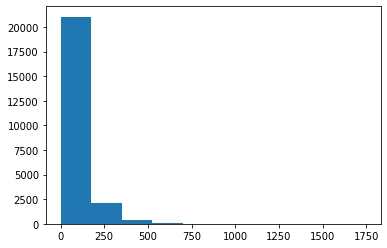

In [18]:
len_list = list(map(len, train_features))
plt.hist(len_list)

In [19]:
train_features = tf.keras.preprocessing.sequence.pad_sequences(train_features, max_len)
test_features = tf.keras.preprocessing.sequence.pad_sequences(test_features, max_len)

In [20]:
train_features.shape

(23703, 100)

In [21]:
for sentence, indexs in zip(train_corpus[:5], train_features[:5]):
    print(f'{sentence} \n {indexs}')
    print()

發言 人 林俐婉 內部 調動 ， 由 江巍峰 接任 。 
 [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0   461    39 35452    89   148     1
    32 18729    95     2]

內部 稽核 主管 林志強 內部 調動 ， 由 莊文清 接任 。 
 [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0   

# Label

In [22]:
train_labels = train['importance'].values.copy()
test_labels = test['importance'].values.copy()

In [23]:
train_labels += 3
test_labels += 3

In [24]:
classes = len(set(train_labels))
print('number of classes', classes)

number of classes 7


# tf Dataset

In [25]:
train_ds = tf.data.Dataset.from_tensor_slices((train_features, train_labels)).shuffle(10000).batch(256)
test_ds = tf.data.Dataset.from_tensor_slices((test_features, test_labels)).batch(256)

In [26]:
print('Train data shape:', train_features.shape)
print('Test data shape', test_features.shape)

Train data shape: (23703, 100)
Test data shape (13014, 100)


# Model

In [27]:
word_vec_dims = 100

In [28]:
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.embedding = tf.keras.layers.Embedding(max_words, word_vec_dims)
        self.gru1 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(word_vec_dims, return_sequences=True))
        self.gru2 = tf.keras.layers.GRU(128, dropout=0.5)
        self.fc1 = tf.keras.layers.Dense(512, activation='relu')
        self.fc2 = tf.keras.layers.Dense(128, activation='relu')
        self.fc3 = tf.keras.layers.Dense(classes, activation='softmax')
    def call(self, inputs):
        x = self.embedding(inputs)
        x = self.gru1(x)
        x = self.gru2(x)
        x = tf.nn.dropout(self.fc1(x), 0.5)
        x = tf.nn.dropout(self.fc2(x), 0.5)
        x = self.fc3(x)
        return x

In [29]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=3,
    mode='max',
    restore_best_weights=True)

In [30]:
model = Model()
loss = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [31]:
history = model.fit(train_ds, epochs=50, validation_data=test_ds, callbacks=[early_stopping])

Epoch 1/50
93/93 [==============================] - 25s 272ms/step - loss: 1.5724 - accuracy: 0.4434 - val_loss: 1.0416 - val_accuracy: 0.5635
Epoch 2/50
93/93 [==============================] - 25s 268ms/step - loss: 1.0143 - accuracy: 0.5912 - val_loss: 0.6128 - val_accuracy: 0.7459
Epoch 3/50
93/93 [==============================] - 25s 269ms/step - loss: 0.6475 - accuracy: 0.7762 - val_loss: 0.4889 - val_accuracy: 0.8497
Epoch 4/50
93/93 [==============================] - 25s 268ms/step - loss: 0.4657 - accuracy: 0.8442 - val_loss: 0.4358 - val_accuracy: 0.8602
Epoch 5/50
93/93 [==============================] - 25s 268ms/step - loss: 0.3802 - accuracy: 0.8722 - val_loss: 0.4170 - val_accuracy: 0.8672
Epoch 6/50
93/93 [==============================] - 25s 270ms/step - loss: 0.3185 - accuracy: 0.8954 - val_loss: 0.4408 - val_accuracy: 0.8708
Epoch 7/50
93/93 [==============================] - 25s 269ms/step - loss: 0.2692 - accuracy: 0.9137 - val_loss: 0.4553 - val_accuracy: 0.8693

In [32]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  5000000   
_________________________________________________________________
bidirectional (Bidirectional multiple                  121200    
_________________________________________________________________
gru_1 (GRU)                  multiple                  126720    
_________________________________________________________________
dense (Dense)                multiple                  66048     
_________________________________________________________________
dense_1 (Dense)              multiple                  65664     
_________________________________________________________________
dense_2 (Dense)              multiple                  903       
Total params: 5,380,535
Trainable params: 5,380,535
Non-trainable params: 0
___________________________________________________

In [49]:
y_pred = tf.argmax(model.predict(test_features), axis=1) - 3
y_true = test['importance']

In [50]:
cm = confusion_matrix(y_true, y_pred, labels=y_true.unique(), normalize='all')

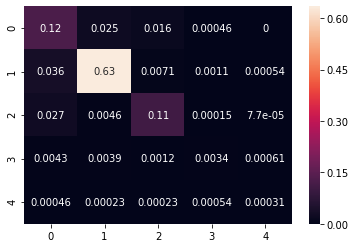

In [51]:
sns.heatmap(cm, annot=True)